# Percentile Forecast Optimization

This notebook focuses on percentile-based forecasts.
It optimizes percentile targets first without aggregation, then with an aggregation window.


## Setup


In [1]:
import pandas as pd
import random
from dataclasses import replace

from replenishment import (
    PercentileForecastOptimizationPolicy,
    build_percentile_forecast_candidates_from_standard_rows,
    build_replenishment_decisions_from_simulations,
    evaluate_aggregation_and_forecast_target_costs,
    evaluate_forecast_target_costs,
    generate_standard_simulation_rows,
    optimize_aggregation_and_forecast_targets,
    optimize_forecast_targets,
    plot_replenishment_decisions,
    replenishment_decision_rows_to_dataframe,
    split_standard_simulation_rows,
    simulate_replenishment_with_aggregation,
    standard_simulation_rows_from_dataframe,
    standard_simulation_rows_to_dataframe,
)


## Generate Sample Data


In [2]:
history_mean = 18
history_std = 2
forecast_mean = 17
forecast_std = 2
replenishment_start_period = 90

rows = generate_standard_simulation_rows(
    n_unique_ids=3,
    periods=120,
    forecast_start_period=replenishment_start_period,
    history_mean=history_mean,
    history_std=history_std,
    forecast_mean=forecast_mean,
    forecast_std=forecast_std,
    initial_on_hand=15,
    current_stock=15,
    lead_time=3,
   # seed=7,
    holding_cost_per_unit=.8,
    stockout_cost_per_unit=1,
    order_cost_per_order=12.5,
    percentile_multipliers={
        "p10": 0.6,
        "p15": 0.65,
        "p20": 0.70,
        "p25": 0.75,
        "p30": 0.80,
        "p35": 0.85,
        "p40": 0.90,
        "p45": 0.95,
        "p50": 1.0,
        "p55": 1.05,
        "p60": 1.10,
        "p65": 1.15,
        "p70": 1.20,
        "p75": 1.25,
        "p80": 1.30,
        "p85": 1.35,
        "p90": 1.40,
    },
)
df = standard_simulation_rows_to_dataframe(rows, library="pandas")


## Split Backtest vs Forecast


In [3]:
backtest_rows, forecast_rows = split_standard_simulation_rows(rows)

# Add simulated actuals for the forecast/replenishment period so we can measure lost sales.
rng = random.Random(7)

def _sample_int(mean: float, std: float) -> int:
    return max(0, int(round(rng.gauss(mean, std))))

forecast_rows_actuals = [
    replace(row, actuals=_sample_int(history_mean, history_std), demand=_sample_int(history_mean, history_std))
    for row in forecast_rows
]
forecast_rows = forecast_rows_actuals

# Rebuild df so plots include actuals in replenishment period.
df = standard_simulation_rows_to_dataframe(
    backtest_rows + forecast_rows, library="pandas"
)


## Step 1: Optimize Percentile Target (No Aggregation)


In [4]:
percentile_configs = build_percentile_forecast_candidates_from_standard_rows(
    backtest_rows,
    include_mean=True,
)
percentile_costs = evaluate_forecast_target_costs(percentile_configs)
percentile_cost_rows = [
    {"unique_id": uid, "target": target, "total_cost": cost}
    for uid, targets in percentile_costs.items()
    for target, cost in targets.items()
]
percentile_cost_df = pd.DataFrame(percentile_cost_rows)
percentile_cost_df


,unique_id,target,total_cost
0,A,p10,2723.0
1,A,p15,2687.0
2,A,p20,2596.0
3,A,p25,2425.0
4,A,p30,2242.0
5,A,p35,2038.0
6,A,p40,1849.4
7,A,p45,1678.4
8,A,p50,1507.4
9,A,p55,1451.6


In [5]:
percentile_result = optimize_forecast_targets(percentile_configs)

forecast_percentile_configs = build_percentile_forecast_candidates_from_standard_rows(
    forecast_rows,
    include_mean=True,
)
forecast_percentile_simulations = {}
for unique_id, config in forecast_percentile_configs.items():
    target = percentile_result[unique_id].target
    policy = PercentileForecastOptimizationPolicy(
        forecast=config.forecast_candidates[target],
        lead_time=config.lead_time,
    )
    forecast_percentile_simulations[unique_id] = simulate_replenishment_with_aggregation(
        periods=config.periods,
        demand=config.demand,
        initial_on_hand=config.initial_on_hand,
        lead_time=config.lead_time,
        policy=policy,
        aggregation_window=1,
        holding_cost_per_unit=config.holding_cost_per_unit,
        stockout_cost_per_unit=config.stockout_cost_per_unit,
        order_cost_per_order=config.order_cost_per_order,
        order_cost_per_unit=config.order_cost_per_unit,
    )

percentile_decision_rows = build_replenishment_decisions_from_simulations(
    forecast_rows,
    forecast_percentile_simulations,
    percentile_target={
        uid: percentile_result[uid].target
        for uid in forecast_percentile_simulations
    },
)
percentile_decision_df = replenishment_decision_rows_to_dataframe(
    percentile_decision_rows,
    library="pandas",
)
percentile_decision_df.head()


,unique_id,ds,quantity,demand,forecast_quantity,forecast_quantity_lead_time,incoming_stock,starting_stock,ending_stock,safety_stock,starting_on_hand,ending_on_hand,current_stock,on_order,backorders,missed_sales,sigma,aggregation_window,percentile_target
0,A,2031-05-24,59,19,20,17,0,15,0,None,15,0,0,59,4,4,None,1,p55
1,A,2031-06-23,14,17,17,18,0,0,0,None,0,0,0,73,21,17,None,1,p55
2,A,2031-07-23,19,18,18,21,0,0,0,None,0,0,0,92,39,18,None,1,p55
3,A,2031-08-22,22,19,17,19,59,59,40,None,20,1,40,55,0,0,None,1,p55
4,A,2031-09-21,20,18,18,16,14,54,36,None,15,0,36,61,3,0,None,1,p55


### Plot (No Aggregation)


0      4
1     17
2     18
3      0
4      0
5      0
6      0
7      0
8      0
9      0
10     0
11     0
12     0
13     0
14     0
15     0
16     0
17     0
18     0
19     0
20     0
21     0
22     0
23     0
24     0
25     0
26     0
27     0
28     0
29     0
Name: missed_sales, dtype: int64


<Axes: title={'center': 'Percentile decisions (no aggregation)'}, xlabel='Date', ylabel='Units'>

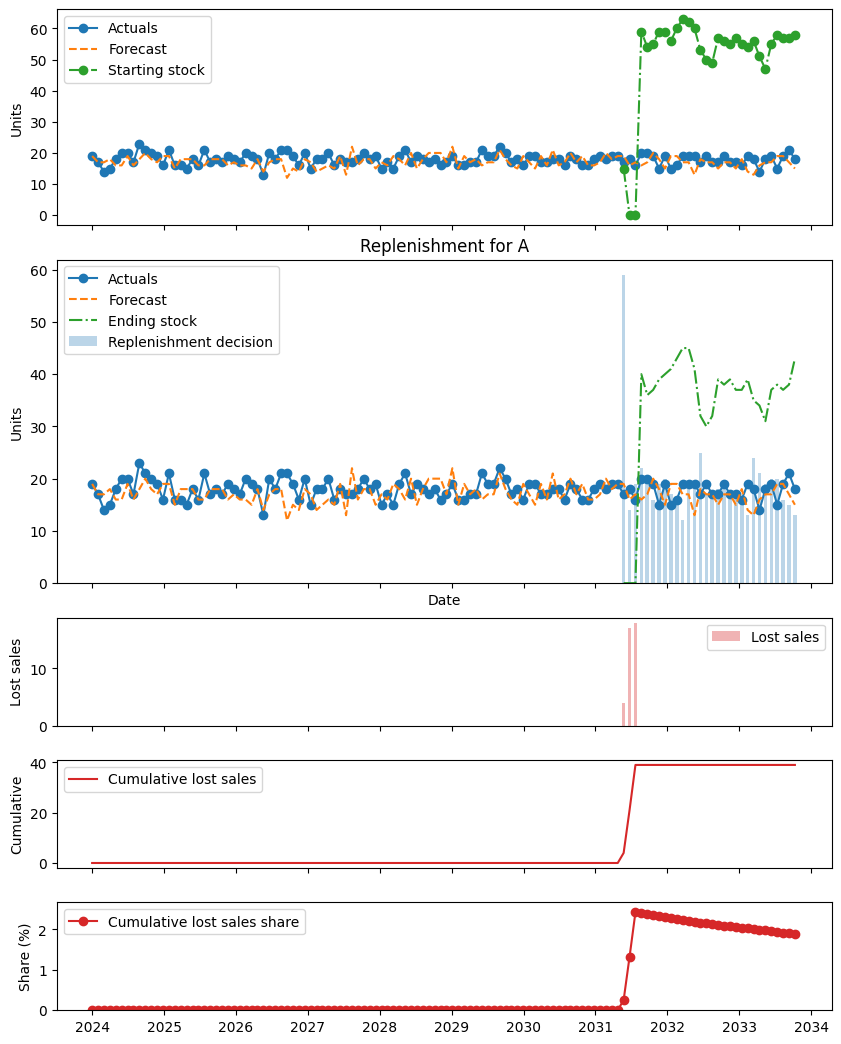

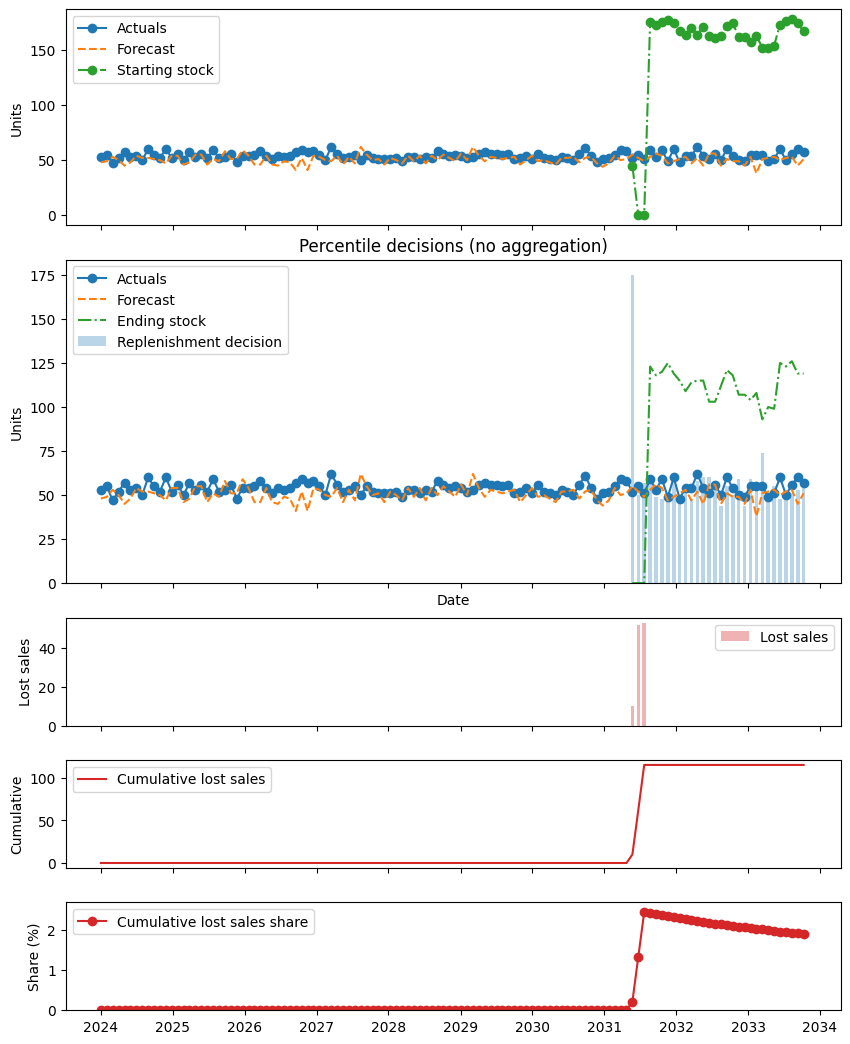

In [6]:
example_id = df["unique_id"].iloc[0]
plot_replenishment_decisions(df, percentile_decision_df, unique_id=example_id)
plot_replenishment_decisions(
    df,
    percentile_decision_df,
    aggregate=True,
    title="Percentile decisions (no aggregation)",
)


## Step 2: Optimize Aggregation Window + Percentile Target


In [7]:
agg_percentile_results = optimize_aggregation_and_forecast_targets(
    percentile_configs,
    candidate_windows=[7, 8, 9, 10],
)

forecast_percentile_configs = build_percentile_forecast_candidates_from_standard_rows(
    forecast_rows,
    include_mean=True,
)
forecast_percentile_simulations = {}
for unique_id, config in forecast_percentile_configs.items():
    choice = agg_percentile_results[unique_id]
    policy = PercentileForecastOptimizationPolicy(
        forecast=config.forecast_candidates[choice.target],
        lead_time=config.lead_time,
    )
    forecast_percentile_simulations[unique_id] = simulate_replenishment_with_aggregation(
        periods=config.periods,
        demand=config.demand,
        initial_on_hand=config.initial_on_hand,
        lead_time=config.lead_time,
        policy=policy,
        aggregation_window=choice.window,
        holding_cost_per_unit=config.holding_cost_per_unit,
        stockout_cost_per_unit=config.stockout_cost_per_unit,
        order_cost_per_order=config.order_cost_per_order,
        order_cost_per_unit=config.order_cost_per_unit,
    )

agg_percentile_decision_rows = build_replenishment_decisions_from_simulations(
    forecast_rows,
    forecast_percentile_simulations,
    aggregation_window={
        uid: agg_percentile_results[uid].window
        for uid in forecast_percentile_simulations
    },
    percentile_target={
        uid: agg_percentile_results[uid].target
        for uid in forecast_percentile_simulations
    },
)
agg_percentile_decision_df = replenishment_decision_rows_to_dataframe(
    agg_percentile_decision_rows,
    library="pandas",
)
agg_percentile_decision_df.head(10)


,unique_id,ds,quantity,demand,forecast_quantity,forecast_quantity_lead_time,incoming_stock,starting_stock,ending_stock,safety_stock,starting_on_hand,ending_on_hand,current_stock,on_order,backorders,missed_sales,sigma,aggregation_window,percentile_target
0,A,2031-05-24,109,19,10.571429,15.000000,0,15,0,None,15,0,0,109,4,4,None,7,p10
1,A,2031-06-23,0,17,10.285714,14.857143,0,0,0,None,0,0,0,109,21,17,None,7,p10
2,A,2031-07-23,0,18,10.428571,14.857143,0,0,0,None,0,0,0,109,39,18,None,7,p10
3,A,2031-08-22,0,19,10.571429,14.571429,109,109,90,None,70,51,90,0,0,0,None,7,p10
4,A,2031-09-21,0,18,10.571429,14.714286,0,90,72,None,51,33,72,0,0,0,None,7,p10
5,A,2031-10-21,0,18,10.571429,14.714286,0,72,54,None,33,15,54,0,0,0,None,7,p10
6,A,2031-11-20,0,20,10.000000,14.428571,0,54,34,None,15,0,34,0,5,0,None,7,p10
7,A,2031-12-20,123,19,10.000000,14.142857,0,34,15,None,0,0,15,123,24,0,None,7,p10
8,A,2032-01-19,0,15,10.142857,14.285714,0,15,0,None,0,0,0,123,39,0,None,7,p10
9,A,2032-02-18,0,17,10.000000,14.142857,0,0,0,None,0,0,0,123,56,17,None,7,p10


### Plot (Optimized Aggregation)


0      4
1     17
2     18
3      0
4      0
5      0
6      0
7      0
8      0
9     17
10     0
11     0
12     0
13     0
14     0
15     0
16     7
17     0
18     0
19     0
20     0
21     0
22     0
23     2
24     0
25     0
26     0
27     0
28     0
29     0
Name: missed_sales, dtype: int64


<Axes: title={'center': 'Percentile decisions (optimized aggregation)'}, xlabel='Date', ylabel='Units'>

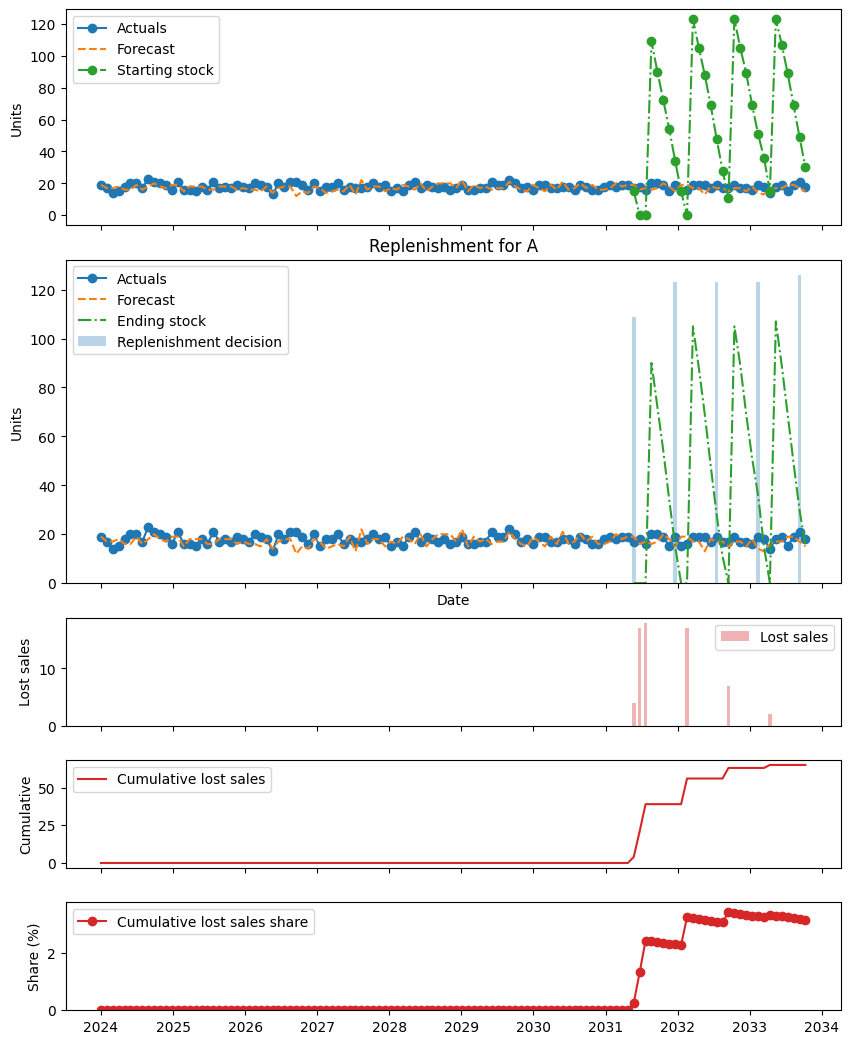

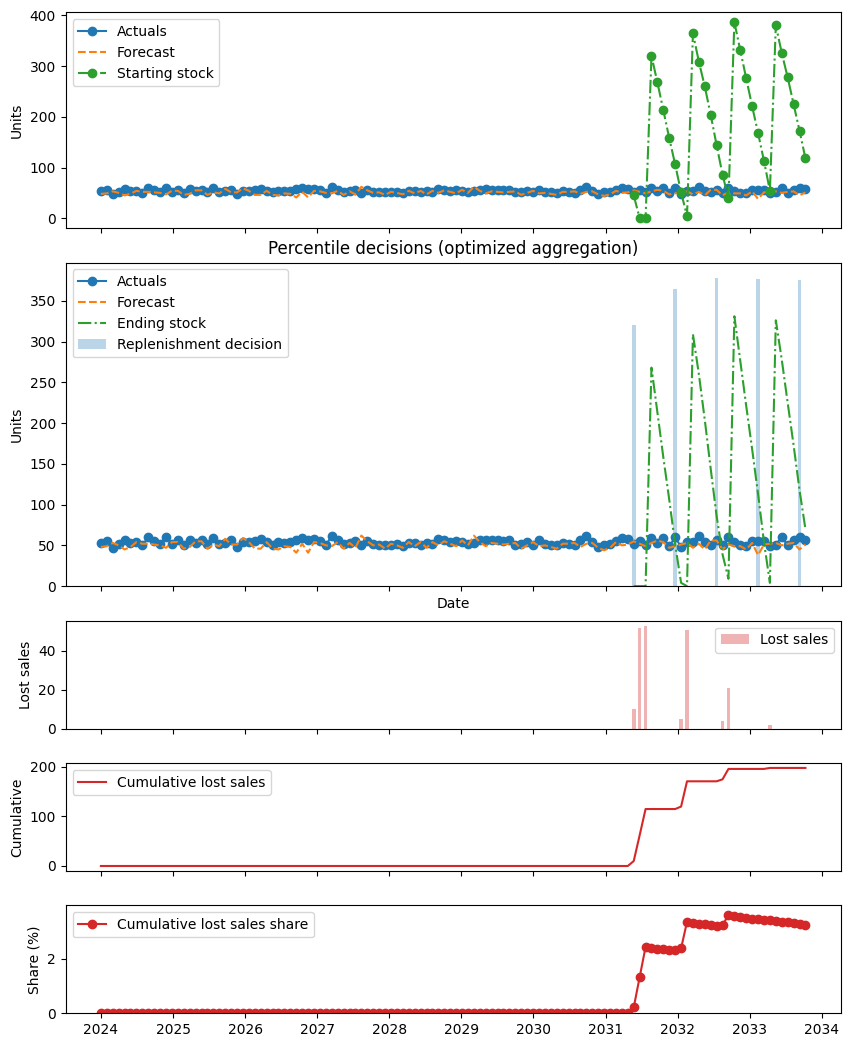

In [8]:
example_id = df["unique_id"].iloc[0]
plot_replenishment_decisions(df, agg_percentile_decision_df, unique_id=example_id)
plot_replenishment_decisions(
    df,
    agg_percentile_decision_df,
    aggregate=True,
    title="Percentile decisions (optimized aggregation)",
)
